# Recommendation System _ Week 7

### Autoencoder and Denoising autoencoder

[AutoRec: Autoencoders meet Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/2740908.2742726)
    
Reference :
- https://github.com/lumiamitie/TIL/blob/master/python/recsys_in_python_101.md 
- 김정학 "추천시스템 6주차.ipynb"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
print(tf.__version__)

2.1.0


In [3]:
# IGNORE this part (same as haggie)
from sklearn.model_selection import train_test_split
import random

event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

articles_df = (
  pd.read_csv('./data/shared_articles.csv').loc[lambda d: d['eventType'] == 'CONTENT SHARED']  
)

interaction_df = pd.read_csv('./data/users_interactions.csv')
interaction_df['eventStrength'] = (
  interaction_df.loc[:, 'eventType'].apply(lambda d: event_type_strength[d])
)


interaction_df_over5 = (interaction_df
  .groupby('personId', group_keys=False)
  .apply(lambda df: df.assign(interactCnt = lambda d: d['contentId'].nunique()))
  .loc[lambda d: d['interactCnt'] >= 5]
)

interaction_full_df = (
  interaction_df_over5
    .groupby(['personId', 'contentId'], as_index=False)['eventStrength']
    .sum()
    .assign(eventScore = lambda d: np.log2(1+d['eventStrength']))
)

interaction_train, interaction_test = train_test_split(
    interaction_full_df,
    stratify=interaction_full_df['personId'],
    test_size=0.2,
    random_state=42
)

interaction_full_indexed = interaction_full_df.set_index('personId')
interaction_train_indexed = interaction_train.set_index('personId')
interaction_test_indexed = interaction_test.set_index('personId')

# Data Preprocessing

In [4]:
articles = pd.read_csv("./data/shared_articles.csv")
user_int = pd.read_csv("./data/users_interactions.csv")

In [5]:
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [6]:
user_int.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


#### Columns to be used for CF in users_interaction.csv: [eventType, contentId, personId]

In [7]:
users = user_int[["eventType","contentId","personId"]].copy()

In [8]:
users.head()

,eventType,contentId,personId
0,VIEW,-3499919498720038879,-8845298781299428018
1,VIEW,8890720798209849691,-1032019229384696495
2,VIEW,310515487419366995,-1130272294246983140
3,FOLLOW,310515487419366995,344280948527967603
4,VIEW,-7820640624231356730,-445337111692715325


#### New column "interaction" containing eventType data converted to corresponding weights

In [9]:
users['interaction'] = (
  users.loc[:, 'eventType'].apply(lambda d: event_type_strength[d])
)

users

,eventType,contentId,personId,interaction
0,VIEW,-3499919498720038879,-8845298781299428018,1.0
1,VIEW,8890720798209849691,-1032019229384696495,1.0
2,VIEW,310515487419366995,-1130272294246983140,1.0
3,FOLLOW,310515487419366995,344280948527967603,3.0
4,VIEW,-7820640624231356730,-445337111692715325,1.0
5,VIEW,310515487419366995,-8763398617720485024,1.0
6,VIEW,-8864073373672512525,3609194402293569455,1.0
7,VIEW,-1492913151930215984,4254153380739593270,1.0
8,VIEW,310515487419366995,344280948527967603,1.0
9,VIEW,3064370296170038610,3609194402293569455,1.0


In [10]:
users = (users
  .groupby('personId', group_keys=False)
  .apply(lambda df: df.assign(interactCnt = lambda d: d['contentId'].nunique()))
  .loc[lambda d: d['interactCnt'] >= 5]
)

users = (
  users
    .groupby(['personId', 'contentId'], as_index=False)['interaction']
    .sum()
    .assign(eventScore = lambda d: np.log2(1+d['interaction']))
)

users.head()

,personId,contentId,interaction,eventScore
0,-9223121837663643404,-8949113594875411859,1.0,1.000000
1,-9223121837663643404,-8377626164558006982,1.0,1.000000
2,-9223121837663643404,-8208801367848627943,1.0,1.000000
3,-9223121837663643404,-8187220755213888616,1.0,1.000000
4,-9223121837663643404,-7423191370472335463,8.0,3.169925


In [11]:
users.describe()

,personId,contentId,interaction,eventScore
count,3.910600e+04,3.910600e+04,39106.000000,39106.000000
mean,-3.550552e+16,-4.828865e+16,2.214954,1.464719
std,5.107185e+18,5.373235e+18,2.834373,0.686355
min,-9.223122e+18,-9.222795e+18,1.000000,1.000000
25%,-3.954277e+18,-4.754224e+18,1.000000,1.000000
50%,-7.450732e+16,-5.924996e+15,1.000000,1.000000
75%,3.829785e+18,4.562045e+18,2.000000,1.584963
max,9.210531e+18,9.222265e+18,230.000000,7.851749


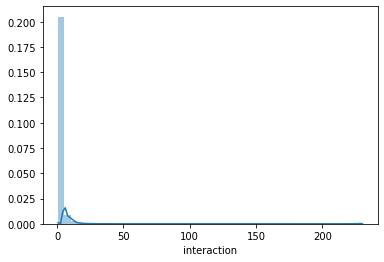

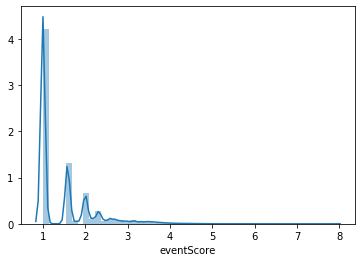

In [12]:
sns.distplot(users["interaction"])
plt.show()

sns.distplot(users["eventScore"])
plt.show()

In [13]:
# Map personId and contentId into more readable format
from sklearn.preprocessing import LabelEncoder
# access original personId by user_enc[encoded_label] (eg. user_enc.classes_[userId_enc] == users["personId"])

user_enc = LabelEncoder()
user_enc.fit(users["personId"])
userId_enc = user_enc.transform(users["personId"])

item_enc = LabelEncoder()
item_enc.fit(users["contentId"])
itemId_enc = item_enc.transform(users["contentId"])

In [14]:
users_data_enc = pd.concat([pd.Series(userId_enc), pd.Series(itemId_enc), users["eventScore"]], axis = 1)
users_data_enc.columns = ["userId","itemId","interaction"]

#### Make a user-item interaction matrix

In [15]:
interaction_matrix = users_data_enc.pivot(index = 'userId', columns = 'itemId', values = "interaction")

In [16]:
interaction_matrix.head()

itemId,0,1,2,3,4,5,6,7,8,9,...,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
interaction_matrix.shape

(1140, 2984)

In [18]:
# Sparsity

print("Sparsity: ", interaction_matrix.isnull().sum().sum() / (interaction_matrix.size) )

Sparsity:  0.9885041860683881


# Model Evaluator

In [19]:
def get_items_interacted(person_id, interaction_df):
    interated_items = interaction_df.loc[person_id]['contentId']
    # else below here is for single value
    return set(interated_items if type(interated_items) == pd.Series else [interated_items])

In [20]:
class ModelEvaluator:
    def __init__(self, n_non_interacted=100):
        
        # get 100 non interacted
        
        self.EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = n_non_interacted
        
    def get_non_interacted_items_sample(self, person_id, sample_size, seed=42):
        
        # on the whole data  "full"
        
        interacted_items = get_items_interacted(person_id, interaction_full_indexed)
        all_items = set(articles_df['contentId'])
        
        non_interacted_items = all_items - interacted_items
        
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        
        # get non interacted sample (sample_size)
        
        return set(non_interacted_items_sample)
        
    def _verify_hit_top_n(self, item_id, recommend_items, topn):

        try:
            index = next(i for i, c in enumerate(recommend_items) if c == item_id)
        except:
            index = -1
            
        hit = int(index in range(0, topn))
        return hit, index
    
    def evaluate_model_for_user(self, model, person_id):
        interacted_values_testset = interaction_test_indexed.loc[person_id]
        
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            # for single value
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        
        # number of items interacted by user
        interacted_items_count_testset = len(person_interacted_items_testset)
        
        # 특정 사용자에 대한 추천 순위 목록을 받아온다
        person_recs = model.recommend_items(
            person_id,
            items_to_ignore=get_items_interacted(person_id, interaction_train_indexed),
            topn=10000000000
        )
        
        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # test셋에서 사용자가 상호작용한 모든 항목에 대해 반복한다
        for item_id in person_interacted_items_testset:
            
            # 사용자가 상호작용하지 않은 100개 항목을 샘플링한다
            non_interacted_items_sample = self.get_non_interacted_items_sample(
                person_id,
                sample_size=self.EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                seed=item_id % (2**32)
            )
            
            # 현재 선택한 item_id(상호작용 있었던 항목)와 100개 랜덤 샘플을 합친다
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            # 추천 결과물 중에서 현재 선택한 item_id와 100개 랜덤 샘플의 결과물로만 필터링한다
            valid_recs = person_recs[person_recs.isin(items_to_filter_recs)].values
            #valid_recs = valid_recs_df['contentId'].values
            
            # 현재 선택한 item_id가 Top-N 추천 결과 안에 있는지 확인한다
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            
        # Recall 값은 상호작용 있었던 항목들 중에서 관련없는 항목들과 섞였을 때 Top-N에 오른 항목들의 비율로 나타낼 수 있다
        recall_at_5 = hits_at_5_count / interacted_items_count_testset
        recall_at_10 = hits_at_10_count / interacted_items_count_testset
        
        person_metrics = {
            'hits@5_count': hits_at_5_count,
            'hits@10_count': hits_at_10_count,
            'interacted_count': interacted_items_count_testset,
            'recall@5': recall_at_5,
            'recall@10': recall_at_10
        }
        return person_metrics
    
    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interaction_test_indexed.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)

        print('{} users processed'.format(idx))
        
        detailed_result = (
            pd.DataFrame(people_metrics)
              .sort_values('interacted_count', ascending=False)
        )
        
        global_recall_at_5 = detailed_result['hits@5_count'].sum() / detailed_result['interacted_count'].sum()
        global_recall_at_10 = detailed_result['hits@10_count'].sum() / detailed_result['interacted_count'].sum()
        
        global_metrics = {
            'model_name': model.get_model_name(),
            'recall@5': global_recall_at_5,
            'recall@10': global_recall_at_10
        }
        
        return global_metrics, detailed_result

In [21]:
class Model:
    def __init__(self, model, user_enc, items_enc, interaction_matrix):
        self.model_name = model
        self.model = eval(model)
        self.user_enc = user_enc
        self.items_enc = items_enc
        self.interaction_matrix = interaction_matrix
        
    def get_model_name(self):
        return self.model_name
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10,verbose=False):
        user_id_enc = user_enc.transform([user_id])
        user_vec = self.interaction_matrix.iloc[user_id_enc[0],:]
        pred_list = self.model.predict([user_vec.tolist()])
        
        return pd.Series(self.items_enc.classes_[np.argsort(pred_list)[::-1]][0][:topn])

In [22]:
model_evaluator = ModelEvaluator(n_non_interacted = 100)

# Autoencoder

* Make recommendation to existing users
* Make recommendation to new users

In [23]:
train_data = interaction_matrix.fillna(0)

In [24]:
# numpy works better than pandas for tensorflow
#train_data = interaction_matrix.fillna(0).values[10:,:]
test_data = interaction_matrix.fillna(0).values[:10,:]

# train_data = interaction_matrix.fillna(0)
# train_data = train_data.apply(lambda x: [1. if i != 0. else 0 for i in x])

AEmodel = tf.keras.Sequential()

input_dim = train_data.shape[1]  #(1140, 2984)

#model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = 500))

AEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim))

#AEmodel.add(tf.keras.layers.Dense(units = 512, input_dim = input_dim))

#AEmodel.add(tf.keras.layers.Dropout(0.1))

#AEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim))

AEmodel.add(tf.keras.layers.Dense(units = input_dim, activation = 'relu'))

AEmodel.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics = ["accuracy"])

In [25]:
AEmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3056640   
_________________________________________________________________
dense_1 (Dense)              (None, 2984)              3058600   
Total params: 6,115,240
Trainable params: 6,115,240
Non-trainable params: 0
_________________________________________________________________


In [26]:
AEmodel.fit(train_data, train_data, epochs = 20, batch_size = 100, validation_split = 0.333,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")])

Train on 753 samples, validate on 377 samples
Epoch 1/20
753/753 [==============================] - 2s 2ms/sample - loss: 0.2019 - accuracy: 0.9837 - val_loss: 0.1605 - val_accuracy: 0.9872
Epoch 2/20
753/753 [==============================] - 1s 819us/sample - loss: 0.1540 - accuracy: 0.9852 - val_loss: 0.1563 - val_accuracy: 0.9867
Epoch 3/20
753/753 [==============================] - 1s 854us/sample - loss: 0.1355 - accuracy: 0.9854 - val_loss: 0.1541 - val_accuracy: 0.9866
Epoch 4/20
753/753 [==============================] - 1s 798us/sample - loss: 0.1229 - accuracy: 0.9856 - val_loss: 0.1501 - val_accuracy: 0.9867
Epoch 5/20
753/753 [==============================] - 1s 796us/sample - loss: 0.1118 - accuracy: 0.9861 - val_loss: 0.1478 - val_accuracy: 0.9868
Epoch 6/20
753/753 [==============================] - 1s 795us/sample - loss: 0.1030 - accuracy: 0.9865 - val_loss: 0.1462 - val_accuracy: 0.9869
Epoch 7/20
753/753 [==============================] - 1s 817us/sample - loss: 0.

In [27]:
print("복원률: ", ((AEmodel.predict(train_data)!=0).astype(int) == train_data).sum().sum() / train_data.size)

복원률:  0.9511435621248429


In [28]:
autoencoder_model = Model("AEmodel", user_enc, item_enc, interaction_matrix.fillna(0))

In [29]:
print('{} 추천 모형을 평가합니다'.format(autoencoder_model.get_model_name()))
pop_global_metrics, pop_detailed_results = model_evaluator.evaluate_model(autoencoder_model)
print('Global Metrics:\n{}'.format(pop_global_metrics))
pop_detailed_results.head(10)

AEmodel 추천 모형을 평가합니다
1139 users processed
Global Metrics:
{'model_name': 'AEmodel', 'recall@5': 0.022756328304781387, 'recall@10': 0.0441063666581437}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,18,9,192,0.093750,0.046875
17,-2626634673110551643,7,4,134,0.052239,0.029851
16,-1032019229384696495,8,4,130,0.061538,0.030769
10,-1443636648652872475,5,1,117,0.042735,0.008547
82,-2979881261169775358,3,1,88,0.034091,0.011364
161,-3596626804281480007,4,1,80,0.050000,0.012500
65,1116121227607581999,3,2,73,0.041096,0.027397
81,692689608292948411,4,1,69,0.057971,0.014493
106,-9016528795238256703,6,2,69,0.086957,0.028986
52,3636910968448833585,3,0,68,0.044118,0.000000


# Denoising Autoencoder

In [30]:
import random
import copy

# data masking (set random positions in the data to 0)

def mask_data(X, N, method = "2D"):
    
    assert isinstance(X, np.ndarray), 'Wrong input type for X'
    
    if method == "1D":
        row = np.where(X != 0)[0]
        pos = row.tolist()
        n = random.randint(1,N)
        mask_index = np.array(random.sample(pos, n))
        masked = np.copy(X)
        masked[mask_index] = 0
        return masked, mask_index
    
    elif method == "2D":
        
        row, col = np.where(X != 0)
        pos = [*zip(row.tolist(), col.tolist())]
        mask_index = np.array(random.sample(pos, N))
        masked = np.copy(X)
        masked[mask_index[:,0], mask_index[:,1]] = 0
    
        return masked, mask_index

In [31]:
# masking at random < 5
masking = lambda x: mask_data(x, 5, method = "1D")
train_masked = np.vstack(np.apply_along_axis(masking, 1, train_data)[:,0])
masked_index = np.apply_along_axis(masking, 1, train_data)[:,1]

In [32]:
DAEmodel = tf.keras.Sequential()

input_dim = train_data.shape[1]  #(1140, 2984)

#model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = 500))

DAEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim))

#DAEmodel.add(tf.keras.layers.Dense(units = 512, input_dim = input_dim))

#model.add(tf.keras.layers.Dropout(0.5))

DAEmodel.add(tf.keras.layers.Dense(units = 1024, input_dim = input_dim))

DAEmodel.add(tf.keras.layers.Dense(units = input_dim, activation='relu'))

DAEmodel.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics = ["accuracy", tf.keras.metrics.RootMeanSquaredError()])

In [33]:
"""
import tensorflow.keras.backend as K

# Define custom loss to discount 0s in the formulation of losses

def custom_loss():

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        y_PRED = y_pred[(y_true != 0)]
        y_TRUE = y_true[(y_true != 0)]
        return K.mean(K.square(y_PRED - y_TRUE))
   
    # Return a function
    return loss

DAEmodel.compile(loss = custom_loss(), optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics = ["accuracy", tf.keras.metrics.RootMeanSquaredError()])
"""

'\nimport tensorflow.keras.backend as K\n\n# Define custom loss to discount 0s in the formulation of losses\n\ndef custom_loss():\n\n    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer\n    def loss(y_true,y_pred):\n        y_PRED = y_pred[(y_true != 0)]\n        y_TRUE = y_true[(y_true != 0)]\n        return K.mean(K.square(y_PRED - y_TRUE))\n   \n    # Return a function\n    return loss\n\nDAEmodel.compile(loss = custom_loss(), optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics = ["accuracy", tf.keras.metrics.RootMeanSquaredError()])\n'

In [34]:
DAEmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              3056640   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 2984)              3058600   
Total params: 7,164,840
Trainable params: 7,164,840
Non-trainable params: 0
_________________________________________________________________


In [35]:
DAEmodel.fit(train_masked, train_data, epochs = 10, batch_size = 150, validation_split = 0.333,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss")])

Train on 753 samples, validate on 377 samples
Epoch 1/10
753/753 [==============================] - 2s 2ms/sample - loss: 0.2012 - accuracy: 0.9825 - root_mean_squared_error: 0.1934 - val_loss: 0.1649 - val_accuracy: 0.9860 - val_root_mean_squared_error: 0.1745
Epoch 2/10
753/753 [==============================] - 1s 942us/sample - loss: 0.1629 - accuracy: 0.9836 - root_mean_squared_error: 0.2077 - val_loss: 0.1691 - val_accuracy: 0.9860 - val_root_mean_squared_error: 0.1803
Epoch 3/10
753/753 [==============================] - 1s 825us/sample - loss: 0.1500 - accuracy: 0.9841 - root_mean_squared_error: 0.2364 - val_loss: 0.1684 - val_accuracy: 0.9859 - val_root_mean_squared_error: 0.1836
Epoch 4/10
753/753 [==============================] - 1s 877us/sample - loss: 0.1422 - accuracy: 0.9838 - root_mean_squared_error: 0.2601 - val_loss: 0.1696 - val_accuracy: 0.9858 - val_root_mean_squared_error: 0.1855
Epoch 5/10
753/753 [==============================] - 1s 855us/sample - loss: 0.1328

In [36]:
print("복원률: ", ((DAEmodel.predict(train_masked)!=0).astype(int) == train_data).sum().sum() / train_data.size)

복원률:  0.9081627084865596


In [37]:
autoencoder_model = Model("DAEmodel", user_enc, item_enc, interaction_matrix.fillna(0))

In [38]:
print('{} 추천 모형을 평가합니다'.format(autoencoder_model.get_model_name()))
pop_global_metrics, pop_detailed_results = model_evaluator.evaluate_model(autoencoder_model)
print('Global Metrics:\n{}'.format(pop_global_metrics))
pop_detailed_results.head(10)

DAEmodel 추천 모형을 평가합니다
1139 users processed
Global Metrics:
{'model_name': 'DAEmodel', 'recall@5': 0.025057530043467145, 'recall@10': 0.05152135003835336}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,17,6,192,0.088542,0.031250
17,-2626634673110551643,10,3,134,0.074627,0.022388
16,-1032019229384696495,11,6,130,0.084615,0.046154
10,-1443636648652872475,7,2,117,0.059829,0.017094
82,-2979881261169775358,3,1,88,0.034091,0.011364
161,-3596626804281480007,7,3,80,0.087500,0.037500
65,1116121227607581999,4,3,73,0.054795,0.041096
81,692689608292948411,4,2,69,0.057971,0.028986
106,-9016528795238256703,7,2,69,0.101449,0.028986
52,3636910968448833585,4,1,68,0.058824,0.014706


In [39]:
test_masked, mask_index = mask_data(test_data, 10)

In [40]:
AEpred_masked = AEmodel.predict(test_masked)
DAEpred_masked = DAEmodel.predict(test_masked)

In [53]:
mask_index[:,0]

array([1, 2, 2, 1, 0])

In [41]:
AEpred_masked[mask_index[:,0],mask_index[:,1]]

array([0.        , 0.        , 0.92150164, 0.        , 0.        ,
       0.00887364, 0.54703933, 0.        , 0.        , 0.        ],
      dtype=float32)

In [42]:
DAEpred_masked[mask_index[:,0],mask_index[:,1]]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08949585, 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [43]:
test_data[mask_index[:,0],mask_index[:,1]]

array([1.       , 1.       , 1.5849625, 1.       , 1.       , 1.5849625,
       1.5849625, 1.       , 1.       , 1.       ])

#### Tried
* deeper layers
* Drop out
* binarizing instead of points
* suggested loss value in "Training Deep Autoencoders for CF"
##### FAILED

### [Training Deep autoencoders for Collaborative Filtering](https://arxiv.org/pdf/1708.01715.pdf)

# Non sparse data

In [44]:
ns_data = pd.read_csv("./data/ratings.csv", index_col = 0) \
                      .fillna(0)

In [45]:
ns_data.shape

(20, 20)

In [46]:
ns_data.head()

,260,1210,356,318,593,3578,1,2028,296,1259,2396,2916,780,541,1265,2571,527,2762,1198,34
User,,,,,,,,,,,,,,,,,,,,
755,1.0,5.0,2.0,0.0,4.0,4.0,2.0,2.0,0.0,3.0,2.0,0.0,5.0,2.0,0.0,4.0,2.0,5.0,0.0,0.0
5277,5.0,3.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,4.0,3.0,2.0,2.0,0.0,2.0,0.0,5.0,1.0,3.0,0.0
1577,0.0,0.0,0.0,5.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,4.0,4.0,1.0,1.0,2.0,3.0,1.0,3.0
4388,0.0,3.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0,0.0,4.0,1.0,3.0,5.0,0.0,5.0,1.0,1.0,2.0
1202,4.0,3.0,4.0,1.0,4.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,0.0,4.0,0.0,3.0,5.0,5.0,0.0,0.0


In [47]:
# numpy works better than pandas for tensorflow
train_data = ns_data.values[4:,:]
test_data = ns_data.values[:4,:]

model = tf.keras.Sequential()

input_dim = train_data.shape[1]  #(16,20)

#model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = 500))

model.add(tf.keras.layers.Dense(units = 10, input_dim = input_dim))

#model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units = input_dim, activation = 'relu'))

model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(lr = 0.005), metrics = ["accuracy"])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                220       
Total params: 430
Trainable params: 430
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(train_data, train_data, epochs = 10, batch_size = 1, validation_split = 0.1,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss")])

Train on 14 samples, validate on 2 samples
Epoch 1/10
14/14 [==============================] - 1s 41ms/sample - loss: 5.9552 - accuracy: 0.0000e+00 - val_loss: 4.8884 - val_accuracy: 0.0000e+00
Epoch 2/10
14/14 [==============================] - 0s 3ms/sample - loss: 5.0349 - accuracy: 0.0714 - val_loss: 4.5194 - val_accuracy: 0.0000e+00
Epoch 3/10
14/14 [==============================] - 0s 4ms/sample - loss: 4.4784 - accuracy: 0.0714 - val_loss: 4.3581 - val_accuracy: 0.0000e+00
Epoch 4/10
14/14 [==============================] - 0s 3ms/sample - loss: 4.0940 - accuracy: 0.0714 - val_loss: 4.1807 - val_accuracy: 0.0000e+00
Epoch 5/10
14/14 [==============================] - 0s 3ms/sample - loss: 3.8043 - accuracy: 0.1429 - val_loss: 3.9567 - val_accuracy: 0.0000e+00
Epoch 6/10
14/14 [==============================] - 0s 3ms/sample - loss: 3.5507 - accuracy: 0.1429 - val_loss: 3.8556 - val_accuracy: 0.0000e+00
Epoch 7/10
14/14 [==============================] - 0s 4ms/sample - loss: 3.

In [50]:
test_masked, mask_index = mask_data(test_data, 5)

pred = model.predict(test_masked)

In [51]:
pred[mask_index[:,0],mask_index[:,1]]

array([0.        , 0.06816871, 2.751681  , 1.7128375 , 1.0867156 ],
      dtype=float32)

In [52]:
test_data[mask_index[:,0],mask_index[:,1]]

array([2., 4., 5., 4., 2.])